<a href="https://colab.research.google.com/github/Mahjabeenqamar1/Assignment_UET/blob/main/FER_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***The code currently runs only with Python2***

# Intuition

With this tutorial, I present how to create a emotion classifier using FER2013 dataset.


FER2013 is a large, publicly available Face Expression Recognition(FER) dataset consisting of 35,887 face crops. The dataset is challenging as the depicted faces vary significantly in terms of person age, face pose, and other factors, reflecting realistic conditions. The dataset is split into training, validation, and test sets samples. All images are grayscale  i.e. only 1 channel  and have a resolution of 48 by 48 pixels.
Basic expression labels are provided for all samples.The goal is to categorize the emotions into the following seven categories:
- Angry
- Disgust
- Fear
- Happy
- Sad
- Surprise
- Neutral

Recognizing the emotions under controlled conditions is simpler. But what makes this task challenging is to account for naturalistic conditions like different poses, illumination, etc and the fact that unposed expressions are often subtle.

Link: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

We will build a Convolutional Neural Networks to identify the expressions.

*Accuracy is an important consideration for any neural network but the focus of this tutorial will be to optimize the network to also do faster inferencing with an acceptable loss of accuracy. Running on a resource constrained device should not be a constraint and expression recognition could be done at the edge. We will see some techniques to achieve this.*

# Loading the data

Dataset used for training is available from Kaggle. You can downloaded it and extract locally or optionally upload to Google drive (requires below cell to download from Drive). 

The below cell downloads the csv from GDrive provided the file id generated from the shared link. 

*For datasets available locally, you can skip the below cell.*

***Note: Download the data from Kaggle before proceeding***



In [ ]:
!pip install googledrivedownloader

fileid="1V0ELMWF5qSmCF4rOuKChnizgp-w49I5a"
filename='fer2013.csv'

from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id=fileid,
                                    dest_path='./'+filename,
                                    unzip=False)
!ls -l

total 294028
-rw-r--r-- 1 root root 301072766 Oct  8 04:31 fer2013.csv
drwxr-xr-x 1 root root      4096 Sep 30 17:12 sample_data


If you have the dataset locally, have the csv file extracted and ready so we can start. The whole dataset is available in a csv. We use pandas to deal with it.

In [ ]:
import pandas

data = pandas.read_csv("fer2013.csv")

# Data sampling and pre-processing

Let's see how the data looks like -

In [ ]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


Each data sample has below entries
- **emotion:** one of the emotion represented as integer
- **pixels:** pixel values for the image.
- **Usage:** whether the sample should be used for training or test.

Now lets see the samples distribution across different sample sets(training or test) and in the emotion classes:

In [ ]:
print('Samples distribution across Usage:')
print(data.Usage.value_counts())

Samples distribution across Usage:
Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64


So we have a total of 35,887 images divided into three data sets:
1. Training - which we will use to train our model, by pairing the input with expected output.
2. PrivateTest - which will be used to validate our model on to fine tune model weights and biases.
3. PublicTest - this dataset will be used to evaluate our model after training is over. This dataset was made public after the competition had officially ended.
It is not expected to use PublicTest dataset anywhere in training phase as the accuracy and error rate estimate will be biased since the model has seen those images. We will be strictly using it to evaluate the trained model.

In [ ]:
print('Samples per emotion:')
print(data.emotion.value_counts())

Samples per emotion:
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64


There are 7 emotions labelled 0 to 6 as discussed earlier. What is obvious from the samples distribution is that there is non-uniformity among different emotion classes
We have ~9k samples for "fear" and only 547 for "disgust". This has a big impact on how well your model can perform. Well, we will try to deal with it.


In [ ]:
print('Number of pixels for a sample:')
print(len(data.pixels[0].split(' ')))

Number of pixels for a sample:
2304


Pixel size for each of the sample is 2304. It can be visulaized as a 2D-matrix of 48x48. We do this conversion prior to feeding it to our network.
The pixel values are in grayscale. They have a single value for each pixel which represent the intensity of the pixel.

Below code cells do the conversion and we will then see how the samples look.

Firstly, dataset is categorzied into training, validation and test sets depending on the `Usage` value for the samples

In [ ]:
train_set = data[(data.Usage == 'Training')]
validation_set = data[(data.Usage == 'PublicTest')]
test_set = data[(data.Usage == 'PrivateTest')]

We label the seven emotion classes and store as a list.

In [ ]:
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
num_classes = len(emotion_labels)

Each sample has 2304 pixels. Converting it to a 2D matrix gives a 48x48 image i.e. width and height is 48 each and depth is 1 as there is only 1 channel (for grayscale image)

In [ ]:
from math import sqrt

depth = 1
height = int(sqrt(len(data.pixels[0].split())))
width = height

Now, lets visualize some of our data. Choose a sample number from the slider and run the cell. It displays the image from training and the emotion class it belongs to:

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  if __name__ == '__main__':


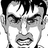

Angry


In [ ]:
#@title Choose a sample to visualize
sample_number = 38 #@param {type:"slider", min:0, max:1000, step:1}

import numpy as np
import scipy.misc
from IPython.display import display

array = np.mat(data.pixels[sample_number]).reshape(48,48)
image = scipy.misc.toimage(array)
display(image)
print(emotion_labels[data.emotion[sample_number]])

To form our input for the neural network, we take the three datasets defined above and reshape them to 48x48x1 numpy arrays

In [ ]:
X_train = np.array(map(str.split, train_set.pixels), np.float32)
X_validation = np.array(map(str.split, validation_set.pixels), np.float32)
X_test = np.array(map(str.split, test_set.pixels), np.float32)

num_train = X_train.shape[0]
num_validation = X_validation.shape[0]
num_test = X_test.shape[0]

X_train = X_train.reshape(num_train, width, height, depth)
X_validation = X_validation.reshape(num_test, width, height, depth)
X_test = X_test.reshape(num_test, width, height, depth)

print('Training: ',X_train.shape)
print('Validation: ',X_validation.shape)
print('Test: ',X_test.shape)

('Training: ', (28709, 48, 48, 1))
('Validation: ', (3589, 48, 48, 1))
('Test: ', (3589, 48, 48, 1))


The value of emotion is one of [0,1,2,3,4,5,6]. We convert it one-hot word encoding such that each emotion is represented as 1x7 vector.

Summarizing the above, the output; a number representing an emotion is transformed to a binary class matrix. Each samples output will be a vector of 7 each representing the particular emotion class.

e.g. if the emotion class is 5 it will become [0. 0. 0. 0. 1. 0. 0.]

In [ ]:
from keras.utils import np_utils

y_train = train_set.emotion
y_train = np_utils.to_categorical(y_train, num_classes)

y_validation = validation_set.emotion
y_validation = np_utils.to_categorical(y_validation, num_classes)

y_test = test_set.emotion
y_test = np_utils.to_categorical(y_test, num_classes)

print('Training: ',y_train.shape)
print('Validation: ',y_validation.shape)
print('Test: ',y_test.shape)

Using TensorFlow backend.


('Training: ', (28709, 7))
('Validation: ', (3589, 7))
('Test: ', (3589, 7))


Below function can be used to view the images in a given set. Due to the large number, we will plot only 50 of them

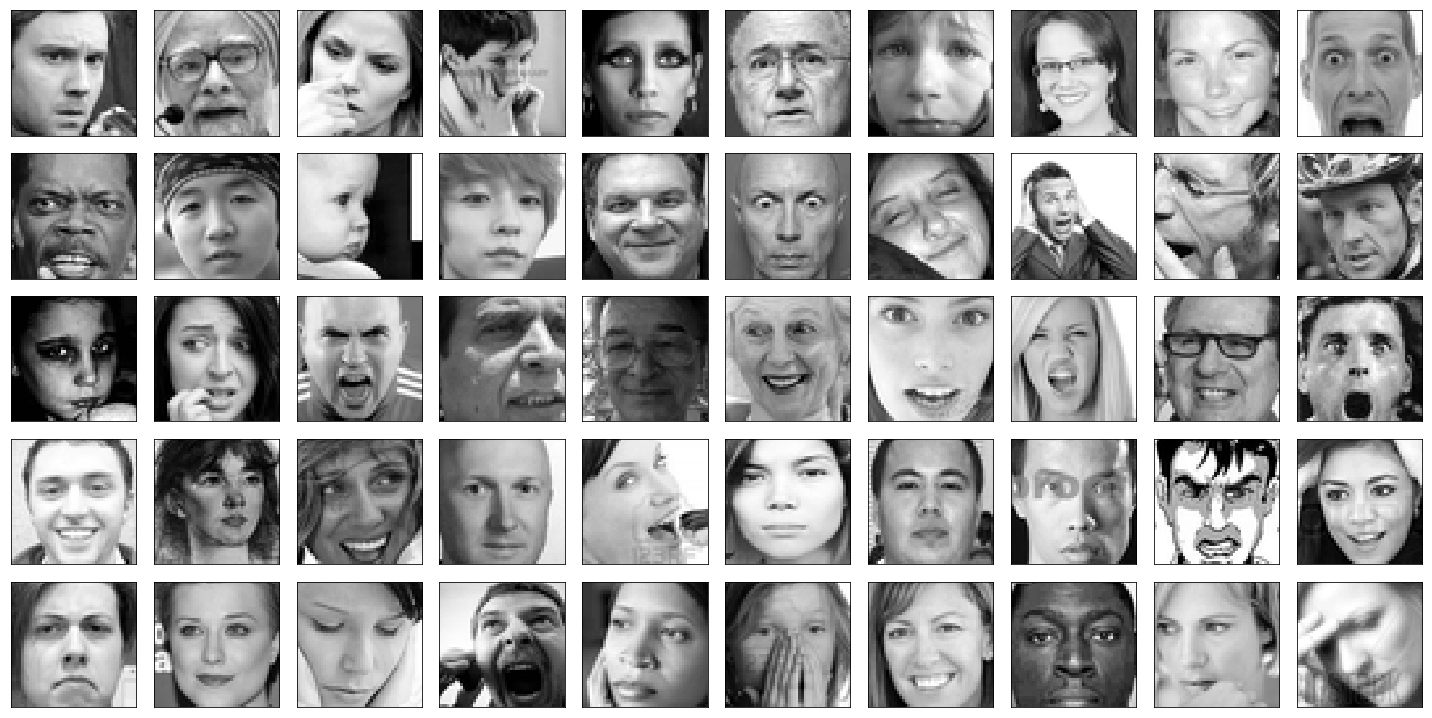

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

def overview(start, end, X):
    fig = plt.figure(figsize=(20,20))
    for i in range(start, end):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(10,10,i+1)
        ax.imshow(input_img[0,:,:,0], cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()
overview(0,50, X_train)

# Building the Network Architecture

Before we go further, an important point of optimization to discuss here is `Winograd convolution`.[4]
If we use a convolution layer with filters of size 3x3; the number of parameters we need to train our network is 9.

Now consider using two layers with dimensions of 3x1 and 1x3. By the property of matrix multiplication, we still get a matrix of 3x3 in theory but an added advantage here would be that the number of paramaters here have reduced to 3+3 = 6 instead of 9 in the former case.

`This comes at a cost of accuracy drop but compared to performance gain, we would be going with the two convolution layers (3x1 and 1x3) instead of one 3x3.`

We use the below layers for our CNN model:

The four initial phases, we try to have features extracted and obtain a verbose feature map.

Phase 1

* Convolutional: Filters- 64, Size: 3x1,Stride- 1, Active padding, Input- 48x48x1
* Convolutional: Filters- 64, Size: 1x3, Stride- 1, Active padding
* Batch Normalization
* Activation: ReLU
* MaxPool: Size- 2x2, Stride- None, Active padding
* Dropout: 0.25

Phase 2

* Convolutional: Filters- 128, Size: 3x1, Stride- 1, Active padding
* Convolutional: Filters- 128, Size: 1x3, Stride- 1, Active padding
* Batch Normalization
* Activation: ReLU
* MaxPool: Size- 2x2, Stride- None, Active padding
* Dropout: 0.25

Phase 3

* Convolutional: Filters- 256, Size: 3x1, Stride- 1, Active padding
* Convolutional: Filters- 256, Size: 1x3, Stride- 1, Active padding
* Batch Normalization
* Activation: ReLU
* MaxPool: Size- 2x2, Stride- None, Active padding
* Dropout: 0.25

Phase 4

* Convolutional: Filters- 512, Size: 3x1, Stride- 1, Active padding
* Convolutional: Filters- 512, Size: 1x3, Stride- 1, Active padding
* Batch Normalization
* Activation: ReLU
* MaxPool: Size- 2x2, Stride- None, Active padding
* Dropout: 0.25

* Flatten

Using this 512 vector space feature map, fully connected layers(FCN or Dense layers) can be used

Phase 5

* FCN: Unit-  512
* Batch Normalization
* Activation: ReLU
* Dropout: 0.25

Phase 6

* FCN: Units-  256
* Batch Normalization
* Activation: ReLU
* Dropout: 0.25

Phase 7

* FCN: Units-  7
* Activation: Softmax

In [ ]:
from keras.layers import Convolution2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten, AveragePooling2D
from keras.models import Sequential

model = Sequential()

model.add(Convolution2D(64, (3, 1), padding='same', input_shape=(48,48,1)))
model.add(Convolution2D(64, (1, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.25))

model.add(Convolution2D(128, (3, 1), padding='same'))
model.add(Convolution2D(128, (1, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.25))

model.add(Convolution2D(256, (3, 1), padding='same'))
model.add(Convolution2D(256, (1, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.25))

model.add(Convolution2D(512, (3, 1), padding='same'))
model.add(Convolution2D(512, (1, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7))
model.add(Activation('softmax'))


Summary representation of the model:

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)      

# Training the network

If seen above we have non-uniform data for different emotion classes and it is limited. To take care of this problem, we do data augmentation by rotating, shifting and flipping and more such combinations to get more data with the already existing one.
Majorly rotation, widht and height shift, and horizontal flip will be required.
This cannot solve the problem of non-uniformity completely as the data difference is large in this case.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator 

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.0,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,   # randomly flip images
    )


datagen.fit(X_train)
datagen.fit(X_validation)

Below, are the hyper-parameters defined for the CNN:
- *Batch size:* determines the number of input samples to be fed to the network together.

- *Epoch:* an epoch is when all of the data is seen by the network once.

In [ ]:
batch_size = 32

num_epochs = 25

Model callbacks: A set of functions to be applied during training
1. Checkpointer: Save the model after every epoch.
2. Reduce LR: Reduce learning rate when a metric has stopped improving
3. Early Stop: Stop training when a monitored quantity has stopped improving.

We define our `fbeta` metric[6] instead of going for `accuracy` in account of Accuracy paradox.[3]
The F-beta score is the weighted harmonic mean of precision and recall, reaching its optimal value at 1 and its worst value at 0.

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

filepath='Model.{epoch:02d}-{val_acc:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')

from keras import backend as K

def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 1

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin), axis=1) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return K.mean((beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon()))

Model compiling configures the model for training. Adam optimizer can be considered an extension to SGD.
And as defined above, our metric will be based on fbeta and accuracy score.

In [ ]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=[fbeta, 'acc'])

We can now train our model we created earlier on the data generated by the previous step of augmentated data.
Here, we mention steps parameter which is nothing but how many steps will be taken to complete a epoch with a given batch size.

On a total of `n` samples taking `k` samples (batch size) and , each epoch will have `n/k` steps

In [ ]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size)
validation_flow = datagen.flow(X_validation, y_validation)

In [ ]:
%%time
history = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=validation_flow, 
                    validation_steps=len(X_validation) / batch_size,
                    callbacks=[checkpointer, reduce_lr, checkpointer])

Epoch 1/25
897/897 [==============================] - 70s 78ms/step - loss: 1.6951 - fbeta: 0.1293 - acc: 0.3420 - val_loss: 1.9203 - val_fbeta: 0.2126 - val_acc: 0.3817

Epoch 00001: saving model to Model.01-0.3817.hdf5

Epoch 00001: saving model to Model.01-0.3817.hdf5
Epoch 2/25
897/897 [==============================] - 63s 70ms/step - loss: 1.3713 - fbeta: 0.2534 - acc: 0.4718 - val_loss: 1.0664 - val_fbeta: 0.2612 - val_acc: 0.5089

Epoch 00002: saving model to Model.02-0.5089.hdf5

Epoch 00002: saving model to Model.02-0.5089.hdf5
Epoch 3/25
897/897 [==============================] - 63s 71ms/step - loss: 1.2746 - fbeta: 0.2997 - acc: 0.5149 - val_loss: 1.2933 - val_fbeta: 0.3226 - val_acc: 0.5389

Epoch 00003: saving model to Model.03-0.5389.hdf5

Epoch 00003: saving model to Model.03-0.5389.hdf5
Epoch 4/25
897/897 [==============================] - 63s 70ms/step - loss: 1.2282 - fbeta: 0.3306 - acc: 0.5336 - val_loss: 1.3411 - val_fbeta: 0.3314 - val_acc: 0.5271

Epoch 00004: 

# Evaluations

Once the model is trained, we run it on test data and see how it performs. The below code gives us the loss and the accuracy of the network when run on test data

In [ ]:
score = model.evaluate(X_test, y_test, steps=len(X_test) / batch_size)
print('Evaluation loss: ', score[0])
print('Evaluation accuracy: ', score[1])

112/112 [==============================] - 170s 2s/step
('Evaluation loss: ', 0.008493475083793913)
('Evaluation accuracy: ', 60.41571396589279)


For the training and validaton sets, lets plot the graphs of accuracy and loss over the epochs

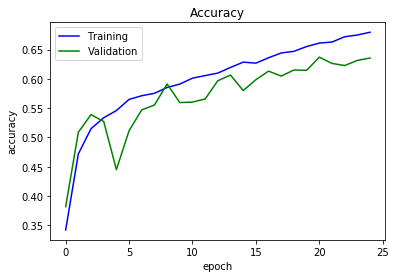

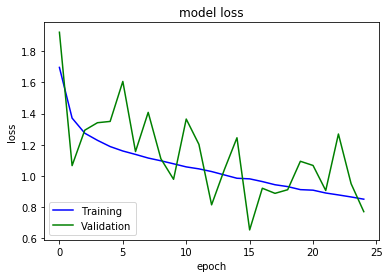

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'], color='b', label='Training')
plt.plot(history.history['val_acc'], color='g', label='Validation')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'], color='b', label='Training')
plt.plot(history.history['val_loss'], color='g', label='Validation')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='lower left')
plt.show()

The correctness of the model can be easily visualized with a confustion matrix(also known as error matrix) oftenly used for classification problems.[5] Correct predictions are located in a diagonal line from top-left to bottom-right.
The confusion matrix shows the ways in which your classification model is confused when it makes predictions.

True positives for a few emotions will be less ofcourse owing to the fact that the training on it was done with a limited data compared to the other emotions which underwent ample of training.

[Text(58.5,0.5,'True label'), Text(0.5,58.5,'Predicted label')]

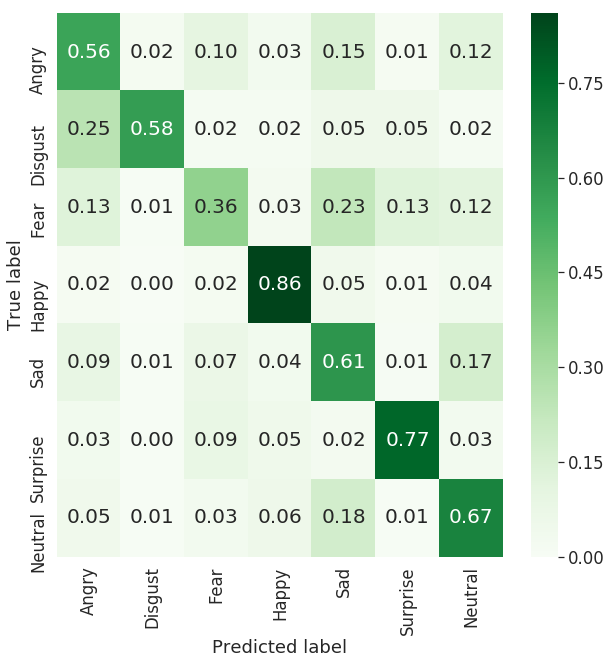

In [ ]:
y_pred = model.predict_classes(X_test)
y_true = np.asarray([np.argmax(i) for i in y_test])

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.set(font_scale=1.5) 
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cm_normalised, annot=True, linewidths=0, square=False, 
                    cmap="Greens", yticklabels=emotion_labels, xticklabels=emotion_labels, vmin=0, vmax=np.max(cm_normalised), 
                    fmt=".2f", annot_kws={"size": 20})
ax.set(xlabel='Predicted label', ylabel='True label')

# Saving the model

In [ ]:
model_json = model.to_json()
with open("model.json","w") as json_file:
     json_file.write(model_json)

model.save('weights.h5')

## Conclusion

***`The human accuracy on this dataset is around 65.5%.`***

[Competition Leaderboard](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/leaderboard)

| No | Team | Score |
| - | - | - |
| 1 | RBM | 0.71161 |
| 2 | Unsupervised | 0.69267 |
| 3 | Maxim Milakov | 0.68821 |
| 4 | Radu+Marius+Cristi | 0.67483 |
| 5 | Lor.Voldy | 0.65254 |
| 6 | ryank | 0.65087 |
| 7 | Eric Cartman | 0.64474 |
| 8 | Xavier Bouthillier | 0.64224 |
| 9 | Alejandro Dubrovsky | 0.63109 |
| 10 | sayit | 0.6219 |

## Techniques used

* Data Augmentation
* Winograd Convolution
* fbeta score
* Batch normalization
* MaxPooling
* Dropout
* Expand and Squeeze
* Model history evaluation
* Confusion matrix

## Further scope

### Training on FER+ dataset [7]

The FER+ annotations provide a set of new labels for the standard Emotion FER dataset. In FER+, each image has been labeled by 10 crowd-sourced taggers, which provide better quality ground truth for still image emotion than the original FER labels. Having 10 taggers for each image enables researchers to estimate an emotion probability distribution per face. This allows constructing algorithms that produce statistical distributions or multi-label outputs instead of the conventional single-label output. [7][8]

# References

[1] [Challenges in Representation Learning](https://arxiv.org/pdf/1307.0414.pdf)

[2] [Keras: The Python Deep Learning library](https://keras.io/)

[3] [Accuracy_paradox](https://en.wikipedia.org/wiki/Accuracy_paradox)

[4] ["Not so fast, FFT": Winograd](https://ai.intel.com/winograd/)

[5] [confusion-matrix-terminology](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)

[6] [F-beta score for Keras](https://www.kaggle.com/arsenyinfo/f-beta-score-for-keras)

[7] [FERPlus](https://github.com/Microsoft/FERPlus)

[8] [Training Deep Networks for Facial Expression Recognition with Crowd-Sourced Label Distribution](https://arxiv.org/abs/1608.01041)